In [2]:
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# # Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Sparsity with L1 penalty: 79.02%
Test score with L1 penalty: 0.8362
Example run in 9.933 s


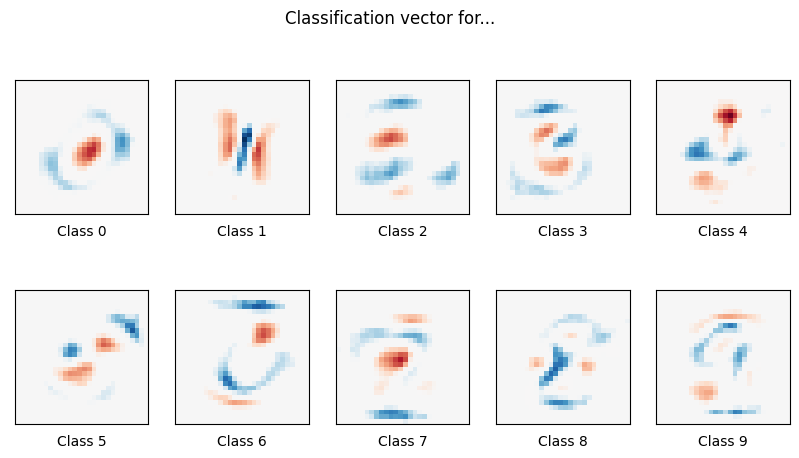

In [3]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
(clf.score(X_test, y_test))


0.8847

In [ ]:
# FFNN from Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2 hidden layers (100 neurons each)
ffnn = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=50)
ffnn.fit(X_train, y_train)
ffnn.score(X_test, y_test)

0.9355

In [6]:
# L1 regularisation (Lasso)
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=50,max_iter=100,tol=0.1)
lasso_reg.fit(X_train,y_train)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [7]:
lasso_reg.score(X_test,y_test)

-6.596979304829276e-06

In [8]:
# L2 regularisation (Ridge)
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train,y_train)

Ridge(alpha=50, max_iter=100, tol=0.1)

In [9]:
ridge_reg.score(X_test,y_test)

0.4277823979305393